# 0. IMPORT

In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import json
import requests
import re
import itertools
import re
import ast
from sklearn.utils import shuffle as sklean_shuffle 
from sklearn.feature_extraction.text import CountVectorizer
import collections as co

import time
from datetime import timedelta
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%matplotlib inline

#for visualisation
%pylab inline
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
sns.set(style="white", color_codes=True)

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

Populating the interactive namespace from numpy and matplotlib


In [3]:
import lightgbm as lgb

In [4]:
payments_df = pd.read_csv('./data/payments_2018.csv' , sep = ';' , error_bad_lines = False, warn_bad_lines = False)
payments_df.columns = ['sku' , 'id_payment' , 'date' , 'time' , 'price' , 'discount' , 'id_place' , 'id_good']
payments_df.drop(axis = 1,columns = ['id_payment'] , inplace = True)
payments_df['date'] = pd.to_datetime(payments_df['date'], format="%d.%m.%Y")

goods_df = pd.read_csv('./data/goods.csv' , sep = ';')

In [5]:
model_df  = pd.merge(payments_df, goods_df[['sku','category_id']], on='sku')

pay_aggr_df = None
pay_aggr_df = model_df.drop(['sku' , 'time' ,'price' ] , axis = 1)[:]

pay_aggr_df = pay_aggr_df.groupby(['date' , 'id_place','id_good' , 'category_id'])[['discount']].count().reset_index()[:]
pay_aggr_df.columns = ['date' , 'id_place','id_good' ,'category_id','count']

In [6]:
pay_aggr_df['count'] = np.log2(pay_aggr_df['count'] + 1)
pay_aggr_df['weekday'] = pay_aggr_df['date'].dt.weekday

Пополним данные о покупках данными о погоде, доступными в data/moscow_weather.json

In [7]:
import json
from pandas.io.json import json_normalize    

with open('./data/moscow_weather.json') as data_file:    
    data = json.load(data_file)  
    
weather = json_normalize(data)
weather['dt'] = pd.to_datetime(weather['dt'],  unit='s')
weather['date'] =  pd.to_datetime(weather.dt.dt.date)
# weather['time'] = weather.dt.dt.time.apply(lambda x: x.strftime('%H:%M'))

weather.drop(['dt', 'dt_iso', 'weather', 'city_id'], axis=1, inplace=True)
weather.fillna(0 , inplace = True)

weather = weather.groupby('date').mean().reset_index()[['date', 'clouds.all', 'main.humidity', 'main.pressure', 'main.temp', 'wind.deg', 'wind.speed']]

In [8]:
pay_aggr_df = pd.merge(pay_aggr_df, weather, on='date')

In [9]:
#add prev days info 
# want_days_back = 10
want_days_back = 5

prev_columns = []
pct_change_columns = []
pct_rename = {}

for d in range(want_days_back):
    # time.sleep(3)
    pay_aggr_df['date_prev'] = pay_aggr_df['date'] - datetime.timedelta(days=d+1)
    
    pay_aggr_df = pd.merge(pay_aggr_df
                           , pay_aggr_df[['date', 'id_place', 'id_good', 'count']]
                           , how='left'
                           , left_on = ['date_prev', 'id_place', 'id_good']
                           , right_on = ['date', 'id_place', 'id_good']
                           #, left_index=True
                           #, right_index=True
                          ).drop(['date_y'] , axis = 1).rename(columns={'date_x':'date'
                                                                        ,'count_x':'count'
                                                                        ,'count_y':'count_prev_'+str(d+1)})
    
    prev_columns.append('count_prev_'+str(d+1))
    pct_change_columns.append('pct_change_'+str(d+1))
    pct_rename['count_prev_'+str(d+1)] = 'pct_change_'+str(d+1)
    
pay_aggr_df.fillna(0 , inplace = True)

print('done')

done


In [10]:
dfDummies = pd.get_dummies(pay_aggr_df['id_place'], prefix = 'id_place')
pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)
dfDummies = pd.get_dummies(pay_aggr_df['id_good'], prefix = 'id_good')
pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)
dfDummies = pd.get_dummies(pay_aggr_df['category_id'], prefix = 'category_id')
pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)
dfDummies = pd.get_dummies(pay_aggr_df['weekday'], prefix = 'weekday')
pay_aggr_df = pd.concat([pay_aggr_df, dfDummies], axis=1)

In [11]:
params = {'bagging_fraction': 0.9455721266302124,
          'bagging_freq': 14,
          'boosting_type': 'gbdt',
          'colsample_bytree': 0.678547801189827,
          'feature_fraction': 0.6204114599267507,
          'max_depth': 14,
          'num_leaves': 48,
          'objective': 'regression',
          'metric': {'l2', 'mse'}}

params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'

# https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric
# l2, square loss, aliases: mean_squared_error, mse
# т.е. l2 эквивалетно mse
params['metric'] = {'l2', 'mse'}

Представим их в виде разряженной матрицы: представление категориальных признаков через pd.get_dummies породило множество признаков в данных, среди которых в каждой строке есть всего несколько нулей.

In [12]:
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

interest_columns = list(set(list(pay_aggr_df.columns)) - set(['date' , 'id_place' , 'id_good' , 'category_id' , 'date_prev' , 'count']))
target_col = 'count'

dataX = csr_matrix(pay_aggr_df[interest_columns].values)
dataY = pay_aggr_df[target_col].values

# X_train = pay_aggr_df[interest_columns].loc[:250000][:]
# X_test = pay_aggr_df[interest_columns].loc[250000:][:]
# y_train = pay_aggr_df[target_col].loc[:250000][:]
# y_test = pay_aggr_df[target_col].loc[250000:][:]

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

lgb_tt = lgb.Dataset(pay_aggr_df[interest_columns][:], pay_aggr_df[target_col][:])

Воспользуемся Scikit-learn API в LightGBM для того, чтобы можно было использовать с моделью поиск по сетке с кросс-валидацией из Scikit-learn. Используем параметры по умолчанию, параметры, подобранные предыдущим программистом, а также добавим несколько промежуточных значений

In [13]:
from sklearn.model_selection import GridSearchCV

estimator = lgb.LGBMRegressor(
    boosting_type='gbdt',
    bagging_fraction=0.9455721266302124,
    # bagging_freq=14,
    colsample_bytree=0.678547801189827,
    feature_fraction=0.6204114599267507,
    max_depth=-1,
)

param_grid = {
    'num_leaves': [48, 100, 200],
    'bagging_freq': [5, 14, 20]
}

model_cv = GridSearchCV(
    estimator, param_grid, cv=3, scoring='neg_mean_squared_error', iid=False, verbose=2)
model_cv.fit(X_train, y_train)

model = model_cv.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] bagging_freq=5, num_leaves=48 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... bagging_freq=5, num_leaves=48, total=   2.7s
[CV] bagging_freq=5, num_leaves=48 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] .................... bagging_freq=5, num_leaves=48, total=   2.0s
[CV] bagging_freq=5, num_leaves=48 ...................................
[CV] .................... bagging_freq=5, num_leaves=48, total=   2.0s
[CV] bagging_freq=5, num_leaves=100 ..................................
[CV] ................... bagging_freq=5, num_leaves=100, total=   2.6s
[CV] bagging_freq=5, num_leaves=100 ..................................
[CV] ................... bagging_freq=5, num_leaves=100, total=   2.7s
[CV] bagging_freq=5, num_leaves=100 ..................................
[CV] ................... bagging_freq=5, num_leaves=100, total=   2.6s
[CV] bagging_freq=5, num_leaves=200 ..................................
[CV] ................... bagging_freq=5, num_leaves=200, total=   3.5s
[CV] bagging_freq=5, num_leaves=200 ..................................
[CV] ................... bagging_freq=5, num_leaves=200, total=   3.5s
[CV] bagging_freq=5, num_leaves=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.7min finished


In [14]:
print(model_cv.best_params_)
print(model_cv.best_score_)

{'bagging_freq': 5, 'num_leaves': 200}
-0.13011603914814052


In [15]:
print(model_cv.best_params_)
print(model_cv.best_score_)

{'bagging_freq': 5, 'num_leaves': 200}
-0.13011603914814052


In [16]:
# model = lgb.train(params, lgb_train, num_boost_round = 100)

In [17]:
feature_names = interest_columns

if isinstance(model, lgb.Booster):
    feature_importances = model.feature_importance()
elif isinstance(model, lgb.LGBMRegressor):
    feature_importances = model.feature_importances_
else:
    raise ValueError

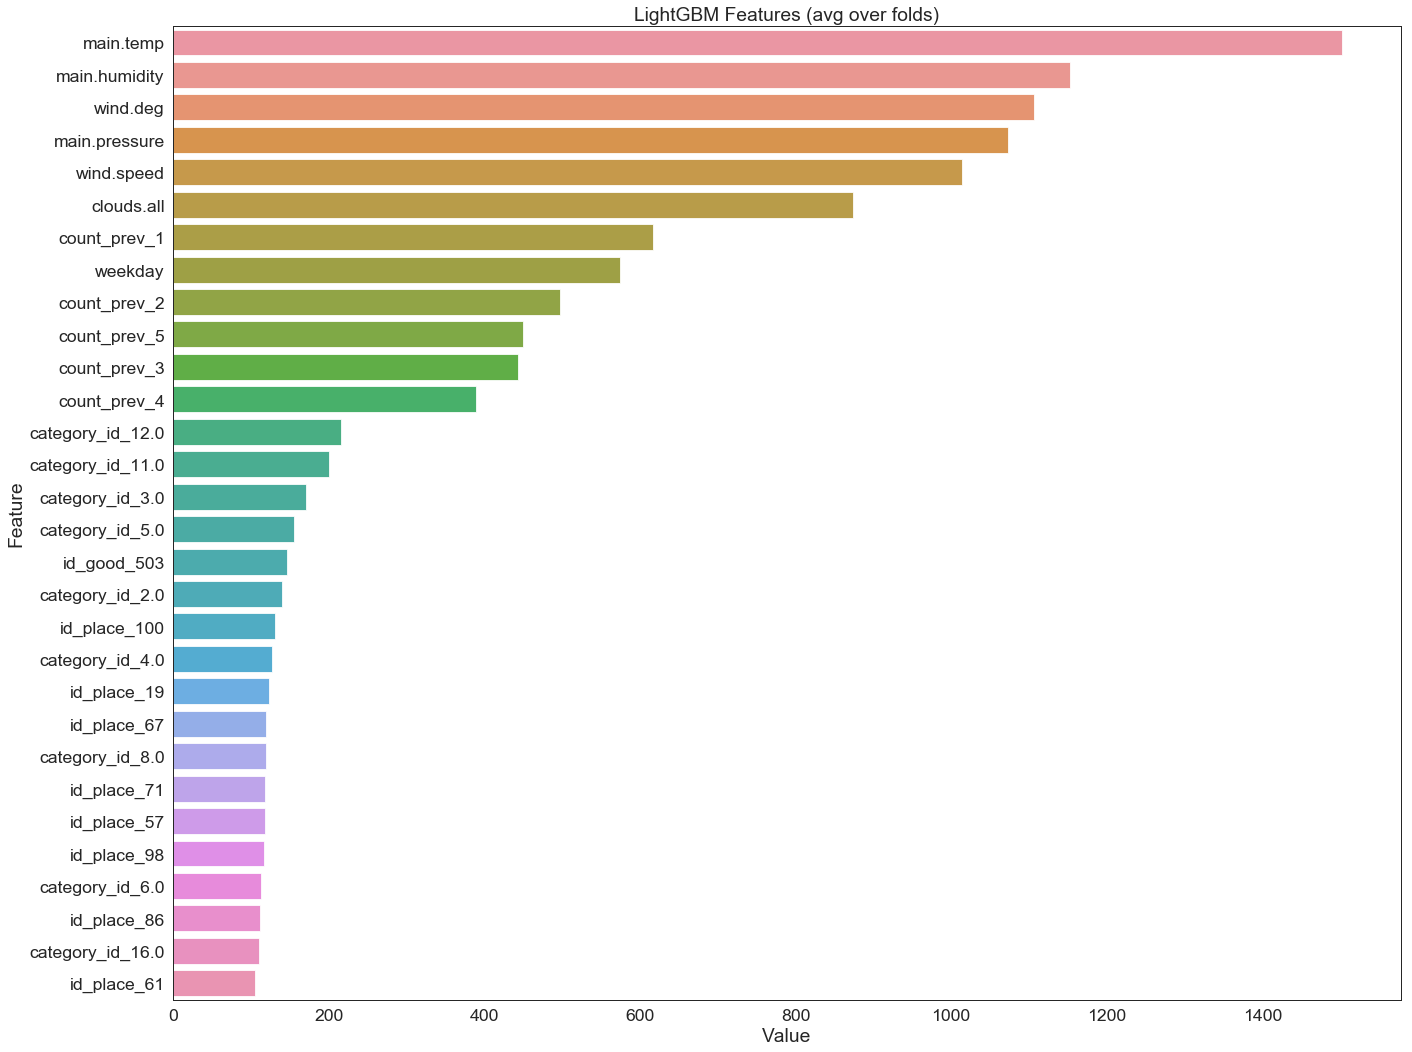

In [18]:
first = 30

sns.set_context("paper", font_scale=2)
feature_imp = pd.DataFrame(sorted(zip(feature_importances, feature_names)), columns=['Value', 'Feature'])

#feature_imp = feature_imp[~(feature_imp.Feature.isin(['dev_max_turnover']))][:]

#feature_imp = feature_imp[int_columns][:]

feature_imp = feature_imp.tail(first)[:]

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')

In [19]:
from sklearn.metrics import mean_squared_error as mse

cnt_predict = model.predict(X_test)
mse(y_test, cnt_predict)

0.12756740693227017

## Задача

Для каждого места id_place и для каждого товара id_good спрогнозировать количество проданного товара. Данная задача важна для правильной организации доставки товаров в магазины и, соотвественно, уменьшение затрат на хранение невостребованых товаров (или убытков от утилизации нереализованных быстропортящихся товаров), а также для уменьшение неполученной прибыли (когда товар в месте продажи кончается, а спрос еще есть)

## Модель
Для решения задачи используется модель линейной регрессии. Таргетом предсказаия является count - количетсво проданного товара. При обуении модели и для оценки качества используется среднеквадратичная ошибка.


## Выводы
После добавления в модель данных о погоде оценка модели значительно не изменилась, однако погодные признаки оказались весьма значимыми в модели после обучения. Вохможно, следует более подробно их рассмотреть в дальнейшей работе